### 1 : Importing Libraries

In [1]:
# ignore the warnings in the output
import warnings
warnings.filterwarnings("ignore")

In [2]:
# import libraries and packages
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import mlflow
from pycaret.classification import *
import sqlite3
from sqlite3 import Error

 ### 2 Reading Data

In [3]:
##Copy the cleaned data obtained from the data_cleaning notebook into the Data folder before proceeding
%time
dataset = pd.read_csv('data/cleaned_data.csv')

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 6.68 µs


In [4]:
dataset.head()

,created_date,city_tier,first_platform_c,first_utm_medium_c,first_utm_source_c,total_leads_droppped,referred_lead,app_complete_flag,assistance_interaction,career_interaction,payment_interaction,social_interaction,syllabus_interaction
0,2021-07-01 00:08:15,1.0,Level0,Level11,Level2,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0
1,2021-07-01 00:16:43,2.0,Level3,Level0,others,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0
2,2021-07-01 00:22:20,1.0,Level3,Level0,Level0,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0
3,2021-07-01 00:23:13,1.0,Level1,Level3,others,2.0,0.0,0,0.0,0.0,0.0,0.0,0.0
4,2021-07-01 00:28:38,1.0,Level3,Level0,Level0,1.0,0.0,0,0.0,0.0,0.0,0.0,0.0


In [5]:
# drop the data column as it is not needed for training
dataset = dataset.drop(['created_date'], axis=1)

### 3 Setting up Environment: 

In [6]:
# create a connection and setup a SQLite database with the name "lead_scoring_model_experimentation.db" in 
# 'Assignment/02_training_pipeline/notebooks/' location

# Creating database path
database_dir = '/home/Assignment/02_training_pipeline/notebooks/'
database_file = 'lead_scoring_model_experimentation.db'
# function to create a connection to the sqlite database at database_dir
def create_sqlit_connection(db_path,db_file):
    """ 
    Description - create a database connection to a SQLite database 
    Input = database path , database file
    output = None
    """
    conn = None
    # creating a connection the sqlite db
    try:
        conn = sqlite3.connect(db_path+db_file)
        print(sqlite3.version) # print the version of sqlite
    except Error as e:
        print(e)
    finally:
        if conn:
            conn.close()
            
# Creating connection to database
create_sqlit_connection(database_dir,database_file)

2.6.0


In [7]:
'''
Now you need to start the MLflow server in a new terminal. 
Note: Before you start the MLflow server, create a folder named mlruns in the assignment directory.
Now you need to run the command to start MLflow server such that:
1. The lead_scoring_model_experimentation.db which you created above is used as the backend-store.
2. mlruns folder is used as an artifact directory. 
3. The server runs on the port 6006.

The steps to do so are as follows:
Open a new terminal.
Then go to the Assignment directory using the cd command. Type the command: cd Assignment/
Create a folder named mlruns here. You can create this folder using either the command line or GUI. To create this folder via the command line run the command: mkdir ./mlruns
Then, type the following command to start the MLflow server: 
mlflow server --backend-store-uri='sqlite:///./02_training_pipeline/notebooks/lead_scoring_model_experimentation.db' --default-artifact-root="./mlruns" --port=6006 --host=0.0.0.0
'''

'\nNow you need to start the MLflow server in a new terminal. \nNote: Before you start the MLflow server, create a folder named mlruns in the assignment directory.\nNow you need to run the command to start MLflow server such that:\n1. The lead_scoring_model_experimentation.db which you created above is used as the backend-store.\n2. mlruns folder is used as an artifact directory. \n3. The server runs on the port 6006.\n\nThe steps to do so are as follows:\nOpen a new terminal.\nThen go to the Assignment directory using the cd command. Type the command: cd Assignment/\nCreate a folder named mlruns here. You can create this folder using either the command line or GUI. To create this folder via the command line run the command: mkdir ./mlruns\nThen, type the following command to start the MLflow server: \nmlflow server --backend-store-uri=\'sqlite:///./02_training_pipeline/notebooks/lead_scoring_model_experimentation.db\' --default-artifact-root="./mlruns" --port=6006 --host=0.0.0.0\n'

In [8]:
# Once, your server is successfully running, create a mlflow tracking uri at "http://0.0.0.0:6006"
mlflow.set_tracking_uri("http://0.0.0.0:6006")

In [9]:
# setup pycaret 
Baseline_model_exp_01 = setup(data = dataset, target = 'app_complete_flag', 
                   session_id = 42,fix_imbalance=False,
                   n_jobs=-1,use_gpu=True,
                   log_experiment=True,experiment_name='Baseline_model_exp_01',
                   log_plots=True, log_data=True,
                   verbose=True,log_profile=False)

,Description,Value
0,session_id,42
1,Target,app_complete_flag
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(238964, 12)"
5,Missing Values,False
6,Numeric Features,7
7,Categorical Features,4
8,Ordinal Features,False
9,High Cardinality Features,False


### 4 : Model Experimentation with pycaret

In [10]:
# create a experimentation with pycaret and exclude ['gbc','knn','qda', 'dummy', 'svm', 'ada']
best_model = compare_models(fold = 5, exclude= ['gbc','knn','qda', 'dummy', 'svm', 'ada'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.7386,0.8211,0.8317,0.7029,0.7619,0.4766,0.4849,0.6520
lightgbm,Light Gradient Boosting Machine,0.7385,0.8211,0.8343,0.7020,0.7624,0.4765,0.4854,4.8300
et,Extra Trees Classifier,0.7367,0.8176,0.8210,0.7044,0.7582,0.4729,0.4797,3.2960
dt,Decision Tree Classifier,0.7364,0.8166,0.8205,0.7041,0.7579,0.4723,0.4789,0.4400
rf,Random Forest Classifier,0.7346,0.8169,0.8394,0.6957,0.7608,0.4686,0.4791,1.3400
lr,Logistic Regression,0.7098,0.7836,0.8221,0.6731,0.7402,0.4189,0.4297,0.4220
ridge,Ridge Classifier,0.7005,0.0000,0.7962,0.6702,0.7278,0.4003,0.4077,0.2040
lda,Linear Discriminant Analysis,0.7005,0.7733,0.7961,0.6702,0.7277,0.4003,0.4077,0.9660
nb,Naive Bayes,0.6629,0.7335,0.8924,0.6134,0.7269,0.3241,0.3653,0.2060


In [11]:
# create a model which gives the highest accuracy
lgbm  = create_model('lightgbm', fold = 5) 

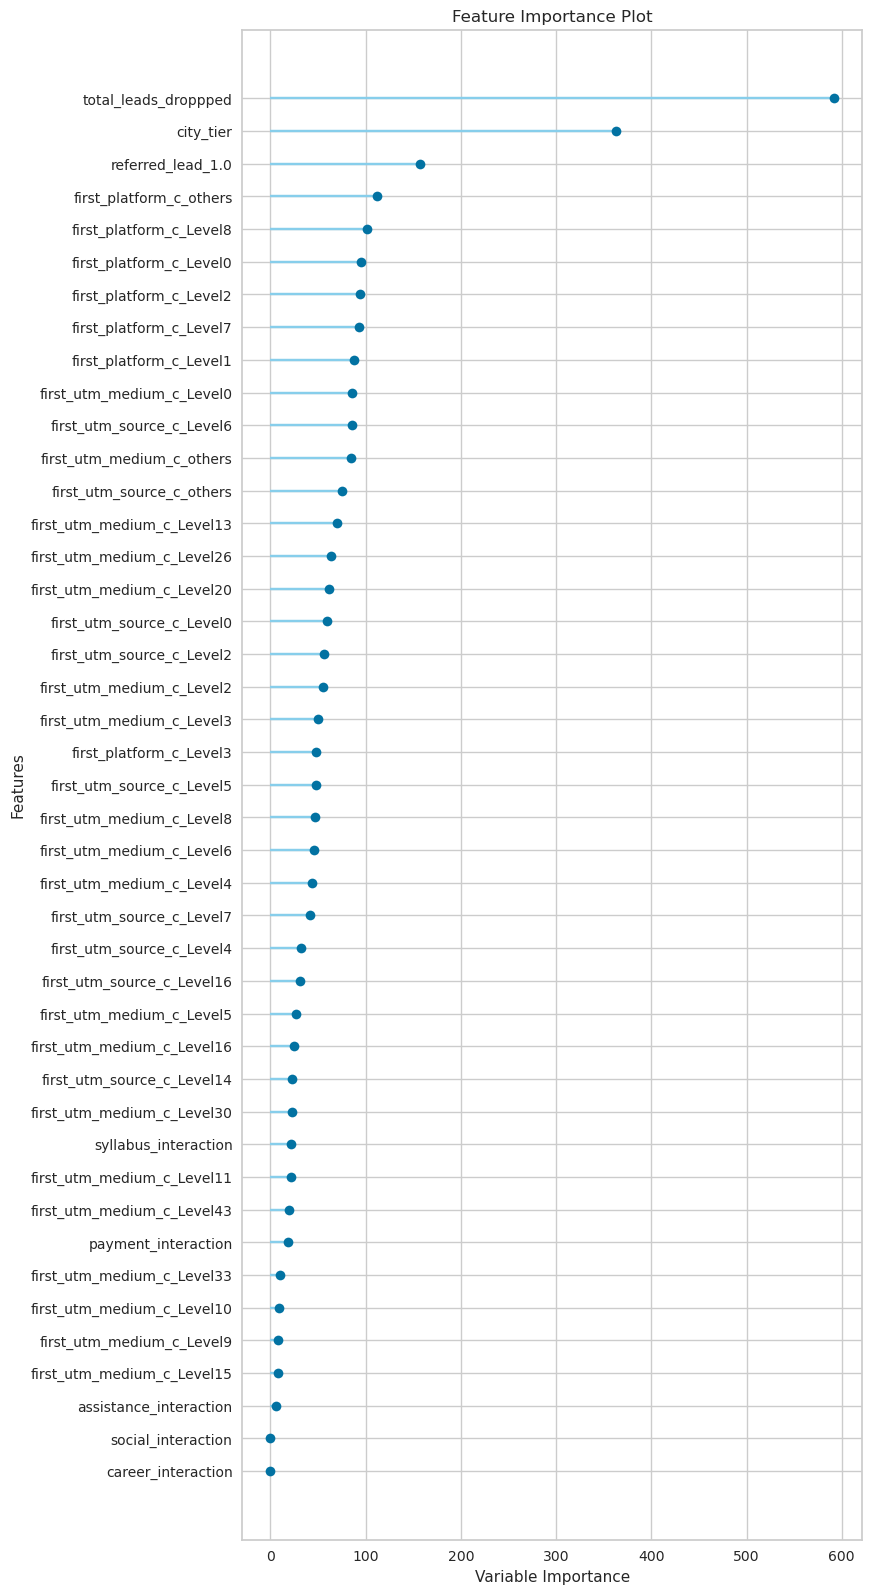

In [12]:
# create feature importance plot
plot_model(lgbm, plot='feature_all')

### 5 : Model Experimentation after dropping features

From the above feature tests we can claerly see that some of the features are not significant. We will now drop all the insignificant features and select only the significant ones.
The list of the significant features is 
['total_leads_droppped', 'city_tier', 'referred_lead', 'app_complete_flag', 'first_platform_c', 'first_utm_medium_c', 'first_utm_source_c'].
So now you will train your model with onlly these features.

Also note that in our previous experiments we saw that tree based models are our top performers. In case of tree based models we do not require transformationss normalization, scaling etc. So make sure that you use setup pycaret in the proper way. i.e, make sure that you use normalize = False and transformation = False.

In [13]:
# 
# ['total_leads_droppped', 'city_tier', 'referred_lead', 'app_complete_flag', 'first_platform_c', 'first_utm_medium_c', 'first_utm_source_c']
final_dataset = dataset[['total_leads_droppped', 'city_tier', 'referred_lead', 'app_complete_flag', 'first_platform_c', 'first_utm_medium_c', 'first_utm_source_c']]

# Train the model using the features listed above. Since we are using tree models we do not require any transformaions 
# such as normalization, scaling etc.So make sure that you use setup pycaret in the proper way. i.e, make sure that you use 
# normalize = False and transformation = False.

Baseline_model_exp_02 = setup(data = final_dataset, target = 'app_complete_flag', 
                   session_id = 42,fix_imbalance=False,
                   n_jobs=-1,use_gpu=True,
                   log_plots=True, log_data=True,
                   verbose=True,log_profile=False,
                   log_experiment=True,experiment_name='Baseline_model_exp_02',
                   normalize = False ,  transformation = False)

,Description,Value
0,session_id,42
1,Target,app_complete_flag
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(238964, 7)"
5,Missing Values,False
6,Numeric Features,2
7,Categorical Features,4
8,Ordinal Features,False
9,High Cardinality Features,False


In [ ]:
# create a experimentation with pycaret and exclude ['gbc','knn','qda', 'dummy', 'svm', 'ada']. 
best_model = compare_models(fold = 5, exclude= ['gbc','knn','qda', 'dummy', 'svm', 'ada'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7385,0.8210,0.8342,0.7020,0.7624,0.4765,0.4853,4.6620
xgboost,Extreme Gradient Boosting,0.7384,0.8209,0.8303,0.7031,0.7614,0.4762,0.4843,0.6040
et,Extra Trees Classifier,0.7366,0.8174,0.8211,0.7042,0.7582,0.4727,0.4795,3.0020
dt,Decision Tree Classifier,0.7363,0.8166,0.8205,0.7041,0.7578,0.4722,0.4788,0.3940
rf,Random Forest Classifier,0.7350,0.8178,0.8432,0.6949,0.7619,0.4693,0.4805,1.3380
lr,Logistic Regression,0.7098,0.7836,0.8222,0.6730,0.7402,0.4188,0.4296,0.1960
ridge,Ridge Classifier,0.7002,0.0000,0.7959,0.6700,0.7275,0.3998,0.4072,0.1720
lda,Linear Discriminant Analysis,0.7002,0.7726,0.7959,0.6700,0.7275,0.3998,0.4072,0.8780
nb,Naive Bayes,0.6701,0.7337,0.8568,0.6255,0.7231,0.3387,0.3650,0.1880


In [ ]:
# You should get lightgbm as the best performing model. So now we will train a lightGBM model manually using pycaret
lgbm  = create_model('lightgbm', fold = 5)

In [ ]:
!pip install optuna

In [ ]:
!pip install optuna-integration[sklearn]

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Tune the hyper parameters of the lightgbm model using optuna on 10 folds and optimise AUC as that was our system metric, 
# hence we will optimise AUC
tuned_lgbm_optuna,tuner = tune_model(lgbm, 
                                    search_library='optuna',
                                    search_algorithm='tpe',
                                    fold = 10,
                                    optimize = 'AUC',
                                    choose_better=True,
                                    return_tuner=True,
                                    n_iter=100,return_train_score=True)

In [21]:
lgbm

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               device='gpu', importance_type='split', learning_rate=0.1,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
               objective=None, random_state=42, reg_alpha=0.0, reg_lambda=0.0,
               silent='warn', subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)